In [73]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt

In [88]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb
%run FeatureAggregationModel.ipynb

In [75]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [76]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
# new_labels = new_labels["class"].map(lambda x : 2 if x == 'unknown' else int(x)-1)
new_labels = labels.replace("unknown", "3")
# labels_new = labels[labels["class"] != "unknown"]
# nodes_new =  nodes.take(indexes)
# edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
# nodes_new.shape, labels_new.shape, edges_new.shape

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [78]:
data, graph_info = time_step_split(nodes, edges, new_labels, device)
for key in data:
    print(key, len(data[key]))

train 31
val 5
test 13


In [79]:
GCN = GNN_Example(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [80]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GCN, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GCN)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "checkpoints/gcn.pt")

Epoch: 10, Loss:0.2838 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.153182    0.872931  0.871809    0.513057      0.794568
recall      0.045399    0.996478  0.871809    0.520939      0.871809
f1-score    0.060416    0.927486  0.871809    0.493951      0.820309
support    98.709677  792.096774  0.871809  890.806452    890.806452
 Train_auc_roc: 0.5209386512245995 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.184615    0.903700   0.90398     0.544158      0.859695
recall       0.056140    0.996410   0.90398     0.526275      0.903980
f1-score     0.086099    0.946611   0.90398     0.516355      0.870229
support    123.400000  942.200000   0.90398  1065.600000   1065.600000
 Val_auc_roc: 0.5262753989508212 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.076923    0.933482   0.93076     0.505202      0.879084
recall      0.000950    0.996552   0.93076   

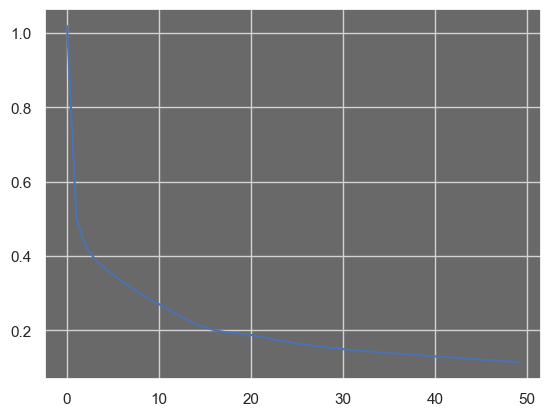

In [81]:
plt.plot(losses)
plt.show()

In [82]:
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

In [83]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(GAT, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(GAT)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "checkpoints/gat.pt")

Epoch: 10, Loss:0.5957 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.396986    0.931141  0.870416    0.664063      0.885542
recall      0.444495    0.908867  0.870416    0.676681      0.870416
f1-score    0.386868    0.917357  0.870416    0.652112      0.871198
support    98.709677  792.096774  0.870416  890.806452    890.806452
 Train_auc_roc: 0.6766811875045673 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.217276    0.956617  0.686712     0.586946      0.889433
recall       0.831467    0.669300  0.686712     0.750383      0.686712
f1-score     0.327625    0.784738  0.686712     0.556181      0.748898
support    123.400000  942.200000  0.686712  1065.600000   1065.600000
 Val_auc_roc: 0.7503833364031982 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.146482    0.986017  0.609969     0.566249      0.935573
recall      0.872144    0.593399  0.609969   

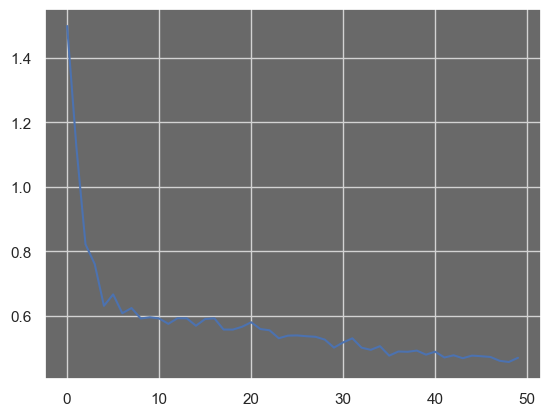

In [84]:
plt.plot(losses)
plt.show()

In [89]:
%run FeatureAggregationModel.ipynb
SFA = SpatialFeatureAggregator(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [90]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(SFA.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(SFA, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(SFA, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(SFA)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "checkpoints/SFA.pt")

Epoch: 10, Loss:0.2019 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.695271    0.948582  0.945236    0.821926      0.942354
recall      0.514597    0.987757  0.945236    0.751177      0.945236
f1-score    0.582303    0.967231  0.945236    0.774767      0.939653
support    98.709677  792.096774  0.945236  890.806452    890.806452
 Train_auc_roc: 0.7511772204334586 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.747519    0.946968  0.939312     0.847243      0.939067
recall       0.591630    0.984193  0.939312     0.787911      0.939312
f1-score     0.650710    0.964537  0.939312     0.807624      0.934779
support    123.400000  942.200000  0.939312  1065.600000   1065.600000
 Val_auc_roc: 0.7879114346830303 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.396715    0.952258  0.946972     0.674487      0.930607
recall      0.196060    0.992818  0.946972   

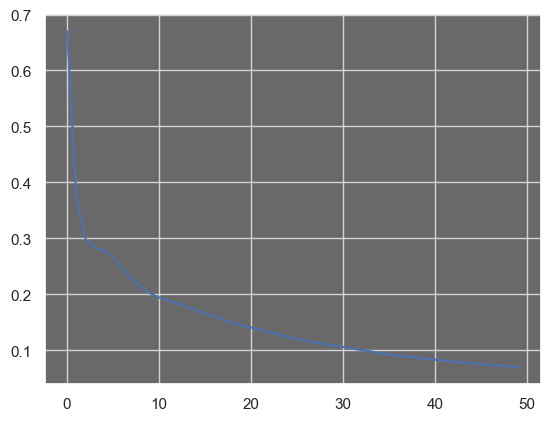

In [91]:
plt.plot(losses)
plt.show()

In [92]:
%run LSTM_GNN.ipynb
TB = TemporalBoy(node_dim=data["train"][0].x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

D:\Python\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [93]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(TB.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(TB, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(TB, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(TB)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "checkpoints/TB.pt")

Epoch: 10, Loss:0.3181 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.096774    0.865940  0.865978    0.481357      0.779165
recall      0.001400    1.000000  0.865978    0.500700      0.865978
f1-score    0.002739    0.924808  0.865978    0.463773      0.807343
support    98.709677  792.096774  0.865978  890.806452    890.806452
 Train_auc_roc: 0.500699832149054 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.408938    0.895819  0.892164     0.652378      0.863932
recall       0.053054    0.994913  0.892164     0.523984      0.892164
f1-score     0.082858    0.940566  0.892164     0.511712      0.850707
support    123.400000  942.200000  0.892164  1065.600000   1065.600000
 Val_auc_roc: 0.5239837230059261 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.289405    0.936514  0.931084     0.612960      0.906162
recall      0.034105    0.993529  0.931084    

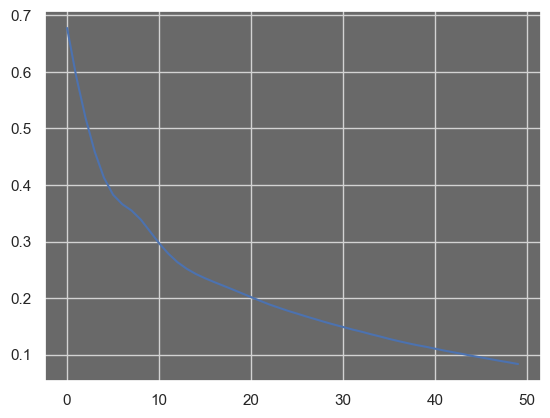

In [94]:
plt.plot(losses)
plt.show()